# GraphCast SAE Demo

This notebook demonstrates loading GraphCast and extracting internal activations.

In [ ]:
%pip install git+https://github.com/theodoremacmillan/graphcast.git@sae-hooks

  Cloning https://github.com/theodoremacmillan/graphcast.git (to revision sae-hooks) to /tmp/pip-req-build-kwty3k9d
  Running command git clone --filter=blob:none --quiet https://github.com/theodoremacmillan/graphcast.git /tmp/pip-req-build-kwty3k9d
  Running command git checkout -b sae-hooks --track origin/sae-hooks
  Switched to a new branch 'sae-hooks'
  Branch 'sae-hooks' set up to track remote branch 'sae-hooks' from 'origin'.
  Resolved https://github.com/theodoremacmillan/graphcast.git to commit 39d1de436148c5658726b5a092bd2d7ef8701f2a
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 163.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 59.5 MB/s eta 0:00:00
   ━━━━━

In [1]:
### Check which graphcast is being used
# Prefer local GraphCast checkout if present; otherwise fall back to pip.
import os, sys, subprocess

repo_root = os.path.abspath(".")
local_repo = os.path.abspath("graphcast")

# Ensure the GraphCast repo root is on sys.path (so graphcast/graphcast is importable)
if os.path.isdir(local_repo):
    sys.path = [p for p in sys.path if os.path.abspath(p) not in (repo_root, "", ".")]
    if local_repo not in sys.path:
        sys.path.insert(0, local_repo)
    print(f"Using local GraphCast repo at {local_repo}")
else:
    subprocess.check_call([
        sys.executable, "-m", "pip", "install",
        "git+https://github.com/theodoremacmillan/graphcast.git@sae-hooks"
    ])

Using local GraphCast repo at /Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast


In [2]:
### Remove paths that can cause namespace imports and ensure local graphcast repo is first.

import os, sys, importlib

repo_root = os.path.abspath(".")
local_repo = os.path.abspath("graphcast")

# Remove paths that cause namespace imports
sys.path = [p for p in sys.path if os.path.abspath(p) not in (repo_root, "", ".")]

# Ensure local repo path is first
if local_repo not in sys.path:
    sys.path.insert(0, local_repo)

# Clean import
sys.modules.pop("graphcast", None)
import graphcast
print("graphcast.__file__:", getattr(graphcast, "__file__", None))
print("graphcast.__path__:", getattr(graphcast, "__path__", None))
print("spec:", importlib.util.find_spec("graphcast.autoregressive"))


graphcast.__file__: /Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/__init__.py
graphcast.__path__: ['/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast']
spec: ModuleSpec(name='graphcast.autoregressive', loader=<_frozen_importlib_external.SourceFileLoader object at 0x103719c10>, origin='/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py')


In [3]:
# @title Workaround for cartopy crashes
# Workaround for cartopy crashes due to the shapely installed by default in
# google colab kernel (https://github.com/anitagraser/movingpandas/issues/81):
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

/Users/guptsh/.pyenv/versions/3.11.7/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Found existing installation: shapely 2.1.2
Uninstalling shapely-2.1.2:
  Successfully uninstalled shapely-2.1.2
  Using cached shapely-2.1.2-cp311-cp311-macosx_15_0_arm64.whl


In [4]:
# @title Imports

import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

import cartopy.crs as ccrs
from google.cloud import storage
from graphcast import autoregressive
from graphcast import casting
from graphcast import checkpoint
from graphcast import data_utils
from graphcast import graphcast
from graphcast import normalization
from graphcast import rollout
from graphcast import xarray_jax
from graphcast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray


def parse_file_parts(file_name):
  return dict(part.split("-", 1) for part in file_name.split("_"))

In [5]:
# @title Authenticate with Google Cloud Storage

gcs_client = storage.Client.create_anonymous_client()
gcs_bucket = gcs_client.get_bucket("dm_graphcast")
dir_prefix = "graphcast/"

In [6]:
import numpy as np
import xarray as xr
import gcsfs


def load_era5_into_memory(
    start: str,
    end: str,
    zarr_path: str = "gs://weatherbench2/datasets/era5/1959-2022-full_37-6h-0p25deg_derived.zarr",
    vars_keep=None,
):
    """
    Load a slice of ERA5 data fully into memory.

    Parameters
    ----------
    start, end : str
        Date range (YYYY-MM-DD)
    zarr_path : str
        GCS or local Zarr path
    vars_keep : list[str] | None
        Variables to keep (None = all)

    Returns
    -------
    xarray.Dataset
        Fully-loaded dataset in memory
    """
    if vars_keep is None:
      vars_keep = [
          "geopotential",
          "specific_humidity",
          "temperature",
          "u_component_of_wind",
          "v_component_of_wind",
          "vertical_velocity",
          "2m_temperature",
          "10m_u_component_of_wind",
          "10m_v_component_of_wind",
          "mean_sea_level_pressure",
          "total_precipitation_6hr",
          "toa_incident_solar_radiation",
          "geopotential_at_surface",
          "land_sea_mask"
      ]

    start = np.datetime64(start)
    end = np.datetime64(end)

    # --- Open Zarr store ---
    if zarr_path.startswith("gs://"):
        fs = gcsfs.GCSFileSystem(token="anon")
        store = fs.get_mapper(zarr_path[5:])
        ds = xr.open_zarr(store, consolidated=True)
    else:
        ds = xr.open_zarr(zarr_path, consolidated=True)

    # --- Normalize coords ---
    rename = {}
    if "latitude" in ds.coords:
        rename["latitude"] = "lat"
    if "longitude" in ds.coords:
        rename["longitude"] = "lon"
    if rename:
        ds = ds.rename(rename)

    if ds.lat[0] > ds.lat[-1]:
        ds = ds.reindex(lat=ds.lat[::-1])

    # --- Time slice ---
    ds = ds.sel(time=slice(start, end))

    # --- Variable selection ---
    if vars_keep is not None:
        ds = ds[[v for v in vars_keep if v in ds.data_vars]]

    # --- LOAD EVERYTHING INTO MEMORY ---
    ds = ds.load()

    return ds

In [7]:
ds = load_era5_into_memory(
    start="2021-08-29",
    end="2021-08-30"
)

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

da = ds["2m_temperature"]  # dims: time, lat, lon

fig, ax = plt.subplots(figsize=(8, 4))
vmin = float(da.min())
vmax = float(da.max())

im = da.isel(time=0).plot(
    ax=ax, cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=True
)
title = ax.set_title(f"2m_temperature | {str(da.time.values[0])}")

def update(i):
    im.set_array(da.isel(time=i).values.ravel())
    title.set_text(f"2m_temperature | {str(da.time.values[i])}")
    return (im,)

anim = FuncAnimation(fig, update, frames=da.sizes["time"], interval=350, blit=False)
plt.close(fig)
HTML(anim.to_jshtml())

ds sizes: Frozen({'batch': 1, 'time': 3, 'lat': 721, 'lon': 1440, 'level': 37})
inputs sizes: Frozen({'batch': 1, 'time': 2, 'lat': 721, 'lon': 1440, 'level': 37})
targets sizes: Frozen({'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440, 'level': 37})
forcings sizes: Frozen({'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440})
ds.time: [             0 21600000000000 43200000000000]
ds.datetime: [['2021-08-29T12:00:00.000000000' '2021-08-29T18:00:00.000000000'
  '2021-08-30T00:00:00.000000000']]


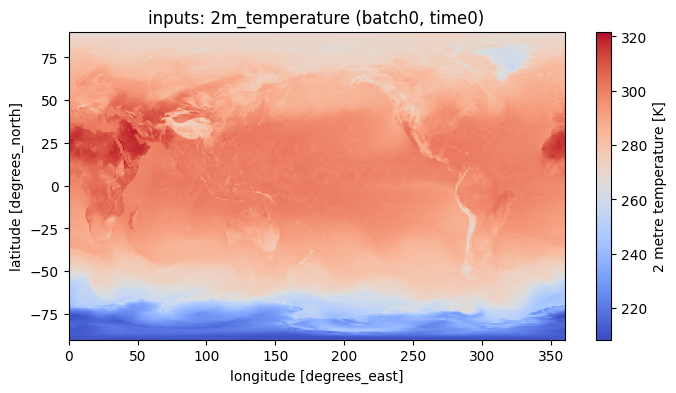

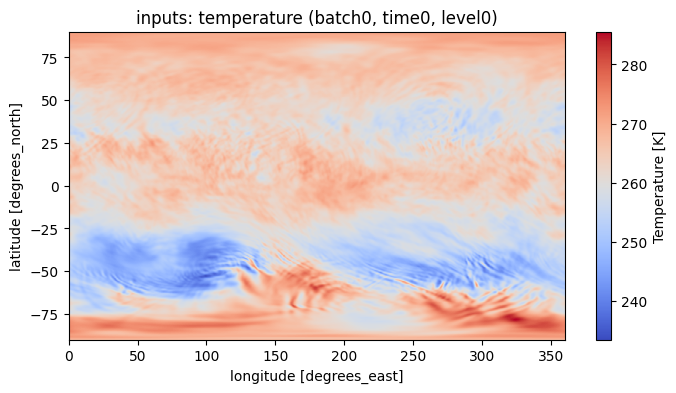

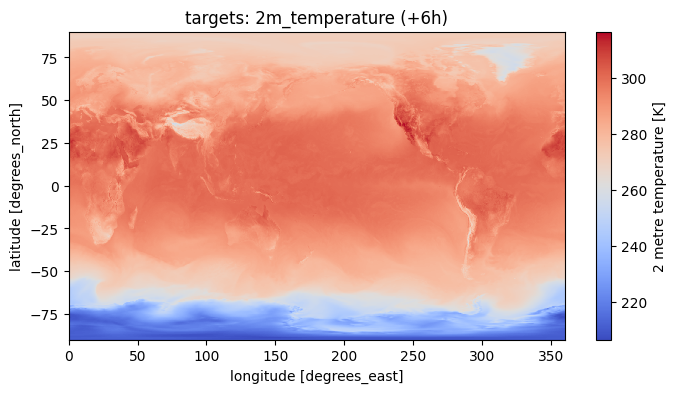

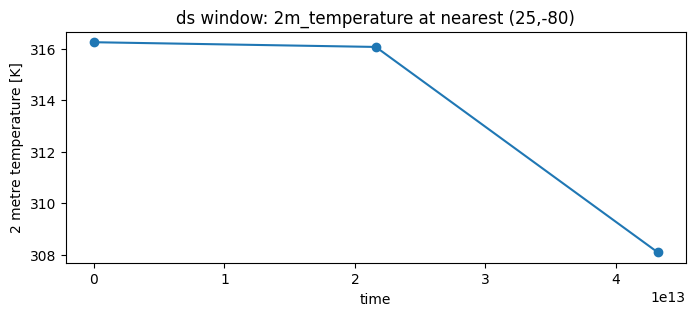

In [16]:
print("ds sizes:", ds.sizes)
print("inputs sizes:", inputs.sizes)
print("targets sizes:", targets.sizes)
print("forcings sizes:", forcings.sizes)

# 1) Time coordinate view
print("ds.time:", ds.time.values)
print("ds.datetime:", ds.datetime.values if "datetime" in ds.coords else "no datetime coord")

# 2) Surface map (no level): 2m temperature at first input time
plt.figure(figsize=(8,4))
inputs["2m_temperature"].isel(batch=0, time=0).plot(cmap="coolwarm")
plt.title("inputs: 2m_temperature (batch0, time0)")
plt.show()

# 3) Pressure-level map: temperature at level index 0, first time
plt.figure(figsize=(8,4))
inputs["temperature"].isel(batch=0, time=0, level=0).plot(cmap="coolwarm")
plt.title("inputs: temperature (batch0, time0, level0)")
plt.show()

# 4) Target map (+6h step)
plt.figure(figsize=(8,4))
targets["2m_temperature"].isel(batch=0, time=0).plot(cmap="coolwarm")
plt.title("targets: 2m_temperature (+6h)")
plt.show()

# 5) Point time series from the 3-step ds window
plt.figure(figsize=(8,3))
ds["2m_temperature"].sel(lat=25, lon=-80, method="nearest").isel(batch=0).plot(marker="o")
plt.title("ds window: 2m_temperature at nearest (25,-80)")
plt.show()

In [9]:
import os
import numpy as np
import xarray as xr

def write_daily_era5_files(ds: xr.Dataset, out_dir: str):
    """
    Write an in-memory ERA5 Dataset to daily NetCDF files
    compatible with three_step_window().

    Assumes:
      - ds has a 'time' coordinate of type datetime64
      - 6-hourly (or finer) resolution
    """

    os.makedirs(out_dir, exist_ok=True)

    # Group by day
    for day, ds_day in ds.groupby("time.date"):
        day_str = np.datetime_as_string(np.datetime64(day), unit="D")
        out_path = os.path.join(out_dir, f"era5_{day_str}.nc")

        # Preserve original encoding as much as possible
        ds_day.to_netcdf(out_path)

        print(f"[WRITE] {out_path}")


In [10]:
# write_daily_era5_files(
#     ds,
#     out_dir = '/content/era5_daily_nc'
# )
write_daily_era5_files(ds, out_dir="./era5_daily_nc")

[WRITE] ./era5_daily_nc/era5_2021-08-29.nc
[WRITE] ./era5_daily_nc/era5_2021-08-30.nc


## Next step is running GraphCast and capturing its internal activations at layer 8

In [11]:
import dataclasses
import functools
import numpy as np
import xarray as xr
import jax
import haiku as hk

from graphcast import (
    autoregressive,
    casting,
    checkpoint,
    data_utils,
    graphcast,
    normalization,
    rollout,
    xarray_jax,
    xarray_tree,
)

try:
    from graphcast.deep_typed_graph_net import get_activation_manager
except ImportError:
    get_activation_manager = None
from google.cloud import storage


In [31]:
# ============================================================
# FULL GraphCast activation pipeline — faithful to original
# ============================================================

import os, glob, dataclasses, functools, time
import numpy as np
import xarray as xr
import jax, haiku as hk
from google.cloud import storage

from graphcast import (
    autoregressive,
    casting,
    checkpoint,
    data_utils,
    deep_typed_graph_net as dtgn,
    graphcast,
    normalization,
    rollout,
    xarray_jax,
    xarray_tree,
)


# ============================================================
# USER INPUTS (YOU SET THESE)
# ============================================================

data_dir = "./era5_daily_nc"  ##"/content/era5_daily_nc"        # contains era5_YYYY-MM-DD.nc
acts_dir = "./graphcast_acts" ##"/content/graphcast_acts"
os.makedirs(acts_dir, exist_ok=True)

SAVE_STEPS = {8}
SAVE_NODE_SET = "mesh_nodes"

_capture_ctx = {"time_tag": "unknown"}
_orig_process = dtgn.DeepTypedGraphNet._process


def set_capture_time_tag(tag: str):
    _capture_ctx["time_tag"] = tag


def _save_activation_callback(nodes_arr, step_idx_arr):
    step_idx = int(np.asarray(step_idx_arr))
    out = os.path.join(
        acts_dir,
        f"layer{step_idx:04d}_mesh_gnn_post_res_nodes_{SAVE_NODE_SET}_t{_capture_ctx['time_tag']}.npy",
    )
    np.save(out, np.asarray(nodes_arr))


def _patched_process(self, latent_graph_0, processor_networks):
    latent_graph = latent_graph_0
    n_steps = len(processor_networks)
    for rep in range(self._num_processor_repetitions):
        for i, processor_network in enumerate(processor_networks):
            latent_graph = processor_network(latent_graph)
            step_idx = rep * n_steps + i

            if getattr(self, "module_name", "") == "mesh_gnn" and step_idx in SAVE_STEPS:
                nodes = latent_graph.nodes[SAVE_NODE_SET].features
                jax.debug.callback(
                    _save_activation_callback,
                    nodes,
                    np.int32(step_idx),
                    ordered=True,
                )
    return latent_graph


dtgn.DeepTypedGraphNet._process = _patched_process
print("Activation capture patch enabled for steps", sorted(SAVE_STEPS))

centers = np.arange(
    np.datetime64("2021-08-29T00"),
    np.datetime64("2021-08-30T00"),
    np.timedelta64(6, "h"),
)


# ============================================================
# ERA5 WINDOWING — *EXACTLY YOUR CODE*
# ============================================================

def _open_and_trim(path: str) -> xr.Dataset:
    ds = xr.open_dataset(path)
    if "time" in ds.dims and ds.sizes["time"] > 4:
        ds = ds.isel(time=slice(0, 4))
    return ds


def three_step_window(data_dir: str, center_time: str) -> xr.Dataset | None:
    t0 = np.datetime64(center_time)
    t_minus = t0 - np.timedelta64(6, "h")
    t_plus  = t0 + np.timedelta64(6, "h")

    needed_days = sorted({
        np.datetime64(t_minus, "D"),
        np.datetime64(t0, "D"),
        np.datetime64(t_plus, "D"),
    })

    file_paths = [
        os.path.join(data_dir, f"era5_{str(d)[:10]}.nc")
        for d in needed_days
    ]

    if any(not os.path.exists(p) for p in file_paths):
        return None

    daily = [_open_and_trim(p) for p in file_paths]

    var_time   = [v for v, da in daily[0].data_vars.items() if "time" in da.dims]
    var_static = [v for v, da in daily[0].data_vars.items() if "time" not in da.dims]

    ds_time = xr.concat([d[var_time] for d in daily], dim="time").sortby("time")
    ds_static = daily[0][var_static]

    ds = xr.merge([ds_time, ds_static])

    target_times = np.array([t_minus, t0, t_plus], dtype=ds.time.dtype)
    if not all(t in ds.time.values for t in target_times):
        return None

    ds = ds.sel(time=target_times)

    ds_new = ds.copy()
    for v in ds_new.data_vars:
        if "time" in ds_new[v].dims:
            ds_new[v] = ds_new[v].expand_dims("batch")

    for c in ds.coords:
        if "time" in ds[c].dims:
            ds_new = ds_new.assign_coords(
                {c: ds[c].expand_dims("batch")}
            )

    time_orig = ds["time"]
    t_ref = time_orig.values[0]
    time_delta = time_orig - t_ref

    ds_new = ds_new.assign_coords(time=time_delta)
    ds_new = ds_new.assign_coords(datetime=("time", time_orig.values))
    ds_new = ds_new.assign_coords(
        {"datetime": ds_new["datetime"].expand_dims("batch")}
    )

    return ds_new


# ============================================================
# LOAD GRAPHCAST + STATS — *EXACTLY YOUR CODE*
# ============================================================

gcs = storage.Client.create_anonymous_client()
bucket = gcs.get_bucket("dm_graphcast")
prefix = "graphcast/"

model_source = (
    "GraphCast - ERA5 1979-2017 - resolution 0.25 - pressure levels 37 "
    "- mesh 2to6 - precipitation input and output.npz"
)

with bucket.blob(f"{prefix}params/{model_source}").open("rb") as f:
    ckpt = checkpoint.load(f, graphcast.CheckPoint)

model_config = ckpt.model_config
task_config = ckpt.task_config
params = ckpt.params
state = {}

with bucket.blob(prefix + "stats/diffs_stddev_by_level.nc").open("rb") as f:
    diffs_stddev_by_level = xr.load_dataset(f).compute()

with bucket.blob(prefix + "stats/mean_by_level.nc").open("rb") as f:
    mean_by_level = xr.load_dataset(f).compute()

with bucket.blob(prefix + "stats/stddev_by_level.nc").open("rb") as f:
    stddev_by_level = xr.load_dataset(f).compute()


# ============================================================
# GRAPHCAST CONSTRUCTION — UNCHANGED
# ============================================================

def construct_wrapped_graphcast(model_config, task_config):
    predictor = graphcast.GraphCast(model_config, task_config)
    predictor = casting.Bfloat16Cast(predictor)
    predictor = normalization.InputsAndResiduals(
        predictor,
        diffs_stddev_by_level=diffs_stddev_by_level,
        mean_by_level=mean_by_level,
        stddev_by_level=stddev_by_level,
    )
    predictor = autoregressive.Predictor(
        predictor, gradient_checkpointing=True
    )
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    return predictor(inputs, targets_template=targets_template, forcings=forcings)


def with_configs(fn):
    return functools.partial(fn, model_config=model_config, task_config=task_config)


def with_params(fn):
    return functools.partial(fn, params=params, state=state)


def drop_state(fn):
    return lambda **kw: fn(**kw)[0]


run_forward_fn = drop_state(
    with_params(
        with_configs(run_forward.apply)
    )
)


# ============================================================
# MAIN LOOP — SAME SEMANTICS AS YOUR SCRIPT
# ============================================================

t_start = time.time()

for center in centers:
    center_str = np.datetime_as_string(center, unit="h")
    print(f"[TIME] {center_str}")

    set_capture_time_tag(center_str)

    ds = three_step_window(data_dir, center_str)
    if ds is None:
        print(f"[MISS] {center_str}")
        continue

    inputs, targets, forcings = data_utils.extract_inputs_targets_forcings(
        ds,
        target_lead_times=slice("6h", "6h"),
        **dataclasses.asdict(task_config),
    )

    _ = rollout.chunked_prediction(
        run_forward_fn,
        rng=jax.random.PRNGKey(0),
        inputs=inputs,
        targets_template=targets * np.nan,
        forcings=forcings,
    )

    print(f"[DONE] {center_str}")

print(f"[ALL DONE] {time.time() - t_start:.1f}s")

Activation capture patch enabled for steps [8]
[TIME] 2021-08-29T00
[MISS] 2021-08-29T00
[TIME] 2021-08-29T06


/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/rollout.py:295: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py:115: FutureWarning: The return type of `Dataset.

[DONE] 2021-08-29T06
[TIME] 2021-08-29T12


/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/rollout.py:295: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py:115: FutureWarning: The return type of `Dataset.

[DONE] 2021-08-29T12
[TIME] 2021-08-29T18


/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/rollout.py:295: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/graphcast/graphcast/autoregressive.py:115: FutureWarning: The return type of `Dataset.

[DONE] 2021-08-29T18
[ALL DONE] 264.6s


In [32]:
# Layers (processor depth)
print("gnn_msg_steps (mesh processor depth):", model_config.gnn_msg_steps)
print("hidden_layers (per-MLP):", model_config.hidden_layers)
print("mesh_size:", model_config.mesh_size)
print("latent_size:", model_config.latent_size)

gnn_msg_steps (mesh processor depth): 16
hidden_layers (per-MLP): 1
mesh_size: 6
latent_size: 512


In [20]:
%pip uninstall graphcast-interpretability

Found existing installation: graphcast-interpretability 0.1.0
Uninstalling graphcast-interpretability-0.1.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/graphcast_interpretability-0.1.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/graphcast_interpretability/*
Proceed (Y/n)? y
  Successfully uninstalled graphcast-interpretability-0.1.0


In [25]:
%pip install git+https://github.com/theodoremacmillan/graphcast-interpretability.git@main


  Cloning https://github.com/theodoremacmillan/graphcast-interpretability.git (to revision main) to /tmp/pip-req-build-ur99otg3
  Running command git clone --filter=blob:none --quiet https://github.com/theodoremacmillan/graphcast-interpretability.git /tmp/pip-req-build-ur99otg3
  Resolved https://github.com/theodoremacmillan/graphcast-interpretability.git to commit 55a02b55d42693fd31c01c0bdf8283d594712e06
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
import os, sys
sys.path.insert(0, os.path.abspath("src"))
from graphcast_interpretability.model import SAE

Using device: cpu


In [34]:
import os
import json
import torch
# from huggingface_hub import hf_hub_download

# # ------------------------------------------------------------
# # Hugging Face model repo (YOU SET THIS)
# # ------------------------------------------------------------

# HF_REPO_ID = "theodoremacmillan/sae-graphcast-k32-lat4096-lay08"
# CKPT_FILENAME = "sae_step0334221_t2300M.pt"
# CFG_FILENAME = "config.json"


# # ------------------------------------------------------------
# # Download checkpoint + config from Hugging Face
# # ------------------------------------------------------------

# ckpt_path = hf_hub_download(
#     repo_id=HF_REPO_ID,
#     filename=CKPT_FILENAME,
# )

# cfg_path = hf_hub_download(
#     repo_id=HF_REPO_ID,
#     filename=CFG_FILENAME,
# )


# ------------------------------------------------------------
# Local checkpoint + config paths (inside current repo)
# ------------------------------------------------------------

CKPT_FILENAME = "sae_step0334221_t2300M.pt"
CFG_FILENAME = "config.json"
BASE_DIR = "./hface-checkpoints"  # change if your folder name differs

ckpt_path = os.path.join(BASE_DIR, CKPT_FILENAME)
cfg_path = os.path.join(BASE_DIR, CFG_FILENAME)

if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Missing checkpoint: {ckpt_path}")
if not os.path.exists(cfg_path):
    raise FileNotFoundError(f"Missing config: {cfg_path}")

print("ckpt_path:", ckpt_path)
print("cfg_path:", cfg_path)


ckpt_path: ./hface-checkpoints/sae_step0334221_t2300M.pt
cfg_path: ./hface-checkpoints/config.json


In [35]:

# ------------------------------------------------------------
# Rest of your code (UNCHANGED)
# ------------------------------------------------------------

# data_dirs = ["/content/graphcast_acts"]
# layer_prefix = "layer0008_"

# out_dir = f"./sae_features_{CKPT_FILENAME.split('.')[0]}"
# os.makedirs(out_dir, exist_ok=True)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # --- Load checkpoint ---
# ckpt = torch.load(ckpt_path, map_location="cpu")

# with open(cfg_path, "r") as f:
#     cfg = json.load(f)

# model = SAE(
#     d_in=cfg.get("d_in", 512),
#     latent=cfg.get("latent", 4096),
#     k_active=cfg.get("k", 32),
#     k_aux=cfg.get("k_aux", 512),
# )

# model.load_state_dict(ckpt["model_state"], strict=False)
# model = model.to(device).eval()

# print("✅ SAE loaded from Hugging Face")

# ------------------------------------------------------------
# Rest of your code (local paths)
# ------------------------------------------------------------

data_dirs = ["./graphcast_acts"]   # was /content/graphcast_acts
layer_prefix = "layer0008_"

out_dir = f"./sae_features_{CKPT_FILENAME.split('.')[0]}"
os.makedirs(out_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Load checkpoint ---
ckpt = torch.load(ckpt_path, map_location="cpu")

with open(cfg_path, "r") as f:
    cfg = json.load(f)

model = SAE(
    d_in=cfg.get("d_in", 512),
    latent=cfg.get("latent", 4096),
    k_active=cfg.get("k", 32),
    k_aux=cfg.get("k_aux", 512),
)

model.load_state_dict(ckpt["model_state"], strict=False)
model = model.to(device).eval()

print("SAE loaded from local checkpoint")

Using device: cpu
SAE loaded from local checkpoint


In [36]:
import os, torch, numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from graphcast import icosahedral_mesh as imesh
import xarray as xr

In [37]:
import os
import glob
import numpy as np
import torch

device = next(model.parameters()).device

# ---------------------------------------------------------
# Collect activation files
# ---------------------------------------------------------

acts_files = []
for d in data_dirs:
    acts_files.extend(
        sorted(glob.glob(os.path.join(d, f"{layer_prefix}*.npy")))
    )

if not acts_files:
    raise RuntimeError("No activation files found")

print(f"Found {len(acts_files)} activation files")


# ---------------------------------------------------------
# In-memory storage
# ---------------------------------------------------------

codes_by_file = {}   # acts_file -> np.ndarray [n_nodes, n_features]
stats_by_file = {}   # optional diagnostics


# ---------------------------------------------------------
# Iterate and run SAE
# ---------------------------------------------------------

for acts_file in acts_files:
    print(f"\nProcessing: {acts_file}")

    X = np.load(acts_file, mmap_mode="r")

    # Reinterpret raw bytes as float16
    if X.dtype == np.dtype("|V2"):
        X = X.view(np.float16)

    # Handle singleton dim
    if X.ndim == 3 and X.shape[1] == 1:
        X = X[:, 0, :]

    # Make writable + move to torch
    X = X.astype(np.float32, copy=True)

    xb = torch.from_numpy(X).to(device)


    with torch.no_grad():
        _, code, _ = model(xb)   # [n_nodes, n_features]

    code_np = code.cpu().numpy()

    codes_by_file[acts_file] = code_np

    stats_by_file[acts_file] = {
        "n_nodes": code_np.shape[0],
        "n_features": code_np.shape[1],
        "sparsity": np.count_nonzero(code_np) / code_np.size,
        "l1_sum": np.sum(np.abs(code_np)),
    }

    print(
        f"Code shape={code_np.shape}, "
        f"sparsity={stats_by_file[acts_file]['sparsity']:.4f}"
    )

print("\n✅ All activations loaded into memory")


Found 3 activation files

Processing: ./graphcast_acts/layer0008_mesh_gnn_post_res_nodes_mesh_nodes_t2021-08-29T06.npy
Code shape=(40962, 4096), sparsity=0.0078

Processing: ./graphcast_acts/layer0008_mesh_gnn_post_res_nodes_mesh_nodes_t2021-08-29T12.npy
Code shape=(40962, 4096), sparsity=0.0078

Processing: ./graphcast_acts/layer0008_mesh_gnn_post_res_nodes_mesh_nodes_t2021-08-29T18.npy
Code shape=(40962, 4096), sparsity=0.0078

✅ All activations loaded into memory


Look at distribution of activations for a single time step

Mean sparsity: 0.0078
Median sparsity: 0.0000


Text(0, 0.5, 'Number of features')

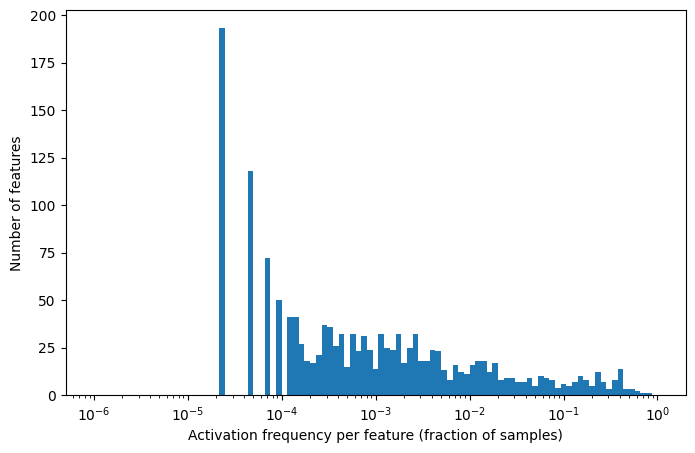

In [38]:
freq = np.count_nonzero(code.cpu(), axis=0) / code.shape[0]  # fraction of samples where feature is active
# freq = np.mean(code**2, axis=0)

print(f"Mean sparsity: {freq.mean():.4f}")
print(f"Median sparsity: {np.median(freq):.4f}")

# =========================================================
# 🎨 Plot histogram
# =========================================================
plt.figure(figsize=(8,5))
plt.hist(freq, bins=np.logspace(-6, 0, 100))
plt.xscale("log")
plt.xlabel("Activation frequency per feature (fraction of samples)")
plt.ylabel("Number of features")

In [40]:
from graphcast_interpretability.interpolate_utils import GridMeshMapper

# era5_file = "/content/era5_daily_nc/era5_2021-08-29.nc"
era5_file = "./era5_daily_nc/era5_2021-08-29.nc"
ds = xr.open_dataset(era5_file)

grid_lat = ds.lat.values
grid_lon = ds.lon.values

mapper = GridMeshMapper(grid_lat, grid_lon, splits=6, cache_dir="./mappings")

g2m_map = mapper.precompute_grid_to_mesh()
m2g_map = mapper.precompute_mesh_to_grid()
# Mesh → Grid (regridding back)


⏳ Building Grid→Mesh radius query mapping …
💾 Saved G→M mapping to /Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/mappings/grid2mesh_s6_r0.01240_gf626d74b.npz
⏳ Building Mesh→Grid triangle-containment mapping …
💾 Saved M→G mapping to /Users/guptsh/Downloads/climate-model-interpretability/graphcast-interpretability/mappings/mesh2grid_s6_gf626d74b.npz


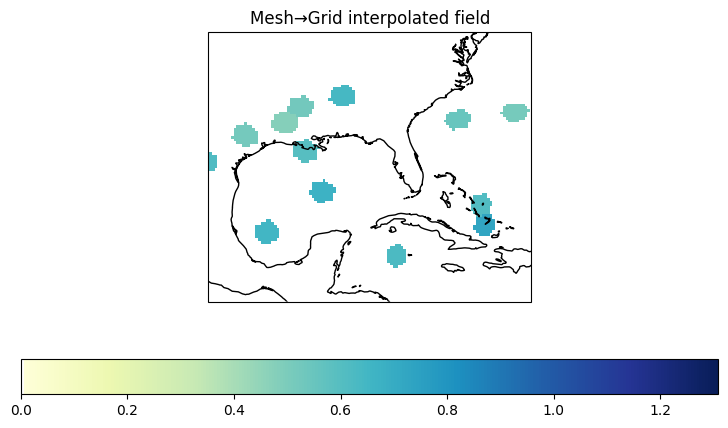

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colors import LinearSegmentedColormap

# use fast interpolator
# regridded = mapper.apply_mesh_to_grid(code[:, 3243].cpu())
regridded = mapper.apply_mesh_to_grid(code[:, 101].cpu())

base = plt.cm.YlGnBu(np.linspace(0, 1, 256))
base[0] = [1, 1, 1, 1]      # white for zero
base[0] = [1, 1, 1, 0]    # transparent instead
cmap = ListedColormap(base)

lon2, lat2 = np.meshgrid(grid_lon, grid_lat)
plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(); ax.set_extent([-100, -70, 15, 40], crs=ccrs.PlateCarree())

pcm = ax.pcolormesh(lon2, lat2, regridded, transform=ccrs.PlateCarree(), cmap=cmap, shading="auto")
plt.colorbar(pcm, ax=ax, orientation="horizontal")
plt.title("Mesh→Grid interpolated field")
plt.show()